# Sources

1. [Spice consumption (2019)](https://www.helgilibrary.com/indicators/spice-consumption-per-capita/)
2. [Life expectancy](https://datacommons.org/explore#q=expected+longevity+per+country&client=ui_query)
3. [Skin cancer stats](https://www.wcrf.org/preventing-cancer/cancer-statistics/skin-cancer-statistics/)
4. [Cancer rates (2022)](https://www.wcrf.org/preventing-cancer/cancer-statistics/global-cancer-data-by-country/)
5. [Countries and codes](https://www.iban.com/country-codes)
6. [Healthcare spending by country (2021)](https://datacommons.org/explore#q=healthcare%20spend%20by%20country)
7. [Cancer mortality per country](https://gco.iarc.fr/today/en/dataviz/scatter-plot?mode=population)

In [79]:
import seaborn as sns
import modin.pandas as pd

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt

import daft as ds


# Utility functions

In [162]:
# Plot style

# Make all the style adjustments as a function. Parameters apart from plot are not necessary.
def style_plot(plot, x_label, y_label, title, legend_title):
    # Despine
    sns.despine()

    # Axis labels, legend, title, subtitle
    plot.set_xlabel(x_label)
    plot.set_ylabel(y_label)
    plot.set_title(title)
    plot.legend(title=legend_title)

    # Set axis labels grey
    plot.xaxis.label.set_color("grey")
    plot.yaxis.label.set_color("grey")

    # Set axis ticks and labels grey
    plot.tick_params(axis="x", colors="grey")
    plot.tick_params(axis="y", colors="grey")

    # Set axis spines grey
    plot.spines["bottom"].set_color("grey")
    plot.spines["left"].set_color("grey")

    # Set legend title and text as grey
    legend_title = plot.get_legend().get_title()
    legend_texts = plot.get_legend().get_texts()
    for i, text in enumerate(legend_texts):
        text.set_color("grey")
    legend_title.set_color("grey")

    # Remove legend border
    plot.get_legend().get_frame().set_linewidth(0.0)

    return plot

# Loading

In [80]:
countries = pd.read_csv("countries.csv")
countries2 = pd.read_csv("countries2.csv")

# Merge the two dataframes
country_merge = pd.merge(countries, countries2, on="alpha3", how="inner")[
    ["country_x", "alpha2", "alpha3", "region", "continent"]
]

# Display the first 5 rows of the merged dataframe
print(country_merge)

                                        country_x alpha2 alpha3  \
0                                         Algeria     DZ    DZA   
1                                          Angola     AO    AGO   
2                                           Benin     BJ    BEN   
3                                        Botswana     BW    BWA   
4                  British Indian Ocean Territory     IO    IOT   
..                                            ...    ...    ...   
243                                          Peru     PE    PER   
244  South Georgia and the South Sandwich Islands     GS    SGS   
245                                      Suriname     SR    SUR   
246                                       Uruguay     UY    URY   
247            Venezuela (Bolivarian Republic of)     VE    VEN   

              region      continent  
0    Northern Africa         Africa  
1      Middle Africa         Africa  
2     Western Africa         Africa  
3    Southern Africa         Africa  
4    

In [81]:
life_expect_2021 = pd.read_csv("life-expect-2021.csv")


In [82]:
spice = pd.read_csv("cons-capita-2019.csv", header=1)
spice.head()

,Yearly Data,Units,2015,2016,2017,2018,2019,Source,Country Code
0,World,kg,1.24849578,1.316749434,1.412744435,1.481640745,1.579426884,"FAOSTAT, Helgi Calculation",NaN
1,Afghanistan,kg,0.029626558,0.288715216,0.280556708,0.272577722,0.132381952,"FAOSTAT, Helgi Calculation",AF
2,Albania,kg,...,...,0.348012864,...,0.350361976,"FAOSTAT, Helgi Calculation",AL
3,Algeria,kg,0.834531307,0.842849915,0.850824957,0.834784129,0.74932032,"FAOSTAT, Helgi Calculation",DZ
4,Angola,kg,0.035552116,...,0.033103125,0.03197592,0.030908473,"FAOSTAT, Helgi Calculation",AO


In [83]:
hcare = pd.read_csv("hcare-spend.csv")

In [84]:
hcare = hcare[["Entity properties isoCode","Variable observation value"]]

# Cleaning

## Spice

In [85]:

import pycountry

# Loaded variable 'df' from URI: /Users/zakhar/Desktop/code/viz-spice-consumption/cons-capita-2019.csv
spice_load = pd.read_csv('cons-capita-2019.csv', engine='pyarrow')

def clean_data(df):
    # Set row 1 as header
    df.columns = df.iloc[0]
    df = df[1:]
    
    # Rename Yearly Data to Country
    df.rename(columns={"Yearly Data": "Country"}, inplace=True) 
    # Drop column: 'Units'
    df = df.drop(columns=['Units'])
    # Remove Country = World
    df = df[df.Country != "World"]

    # For 2015-2019, replace ... with 0
    df.replace("...", 0, inplace=True)

    # Set 2015-2019 to numeric
    df[["2015", "2016", "2017", "2018", "2019"]] = df[
        ["2015", "2016", "2017", "2018", "2019"]
    ].apply(pd.to_numeric)
    
    if 'Country Code' not in df.columns:
        df['Country Code'] = df['Yearly Data'].apply(lambda x: pycountry.countries.get(name=x).alpha_2 if pycountry.countries.get(name=x) else None)
    return df



spice = clean_data(spice_load.copy())
spice.head()

,Country,2015,2016,2017,2018,2019,Source,Country Code
2,Afghanistan,0.029627,0.288715,0.280557,0.272578,0.132382,"FAOSTAT, Helgi Calculation",AF
3,Albania,0.000000,0.000000,0.348013,0.000000,0.350362,"FAOSTAT, Helgi Calculation",AL
4,Algeria,0.834531,0.842850,0.850825,0.834784,0.749320,"FAOSTAT, Helgi Calculation",DZ
5,Angola,0.035552,0.000000,0.033103,0.031976,0.030908,"FAOSTAT, Helgi Calculation",AO
6,Argentina,0.185477,0.183527,0.204337,0.202272,0.244778,"FAOSTAT, Helgi Calculation",AR


## Cancer cases

In [86]:
cancer = pd.read_csv("cancer-rates.csv")
cancer.head()

,Both sexes,Number,ASR (World),Country Code
0,World,"19,976,499",196.9,WD
1,China,"4,824,703",201.6,CH
2,US,"2,380,189",367.0,US
3,India,"1,413,316",98.5,IN
4,Japan,"1,005,157",267.1,JP


In [87]:
cancer.dtypes

Both sexes       object
Number           object
ASR (World)     float64
Country Code     object
dtype: object

In [88]:
# Rename Both sexes to Country
cancer.rename(columns={"Both sexes": "Country"}, inplace=True)

# Remove Country = World
cancer = cancer[cancer.Country != "World"]

# Remove commas from Number column rows
if cancer["Number"].dtype == "object":
    cancer["Number"] = cancer["Number"].str.replace(",", "")

# Convert Number to numeric
cancer["Number"] = cancer["Number"].apply(pd.to_numeric)

# Rename ASR (World) to ASR
cancer.rename(columns={"ASR (World)": "ASR"}, inplace=True)

In [89]:
cancer.head()

,Country,Number,ASR,Country Code
1,China,4824703,201.6,CH
2,US,2380189,367.0,US
3,India,1413316,98.5,IN
4,Japan,1005157,267.1,JP
5,Russia,635560,248.1,RU


## Life expectancy

In [90]:
# Load
life = pd.read_csv("life-expect-2021.csv")

life.head()

# Take columns Entity properties isoCode, Entity properties name, Variable observation value as ccode, country, life_expectancy
life = life[
    [
        "Entity properties isoCode",
        "Entity properties name",
        "Variable observation value",
    ]
]
life.rename(
    columns={
        "Entity properties isoCode": "ccode",
        "Entity properties name": "country",
        "Variable observation value": "value",
    },
    inplace=True,
)


In [91]:
life.head()

,ccode,country,value
0,AW,Aruba,74.626
1,AF,Afghanistan,61.982
2,AO,Angola,61.643
3,AL,Albania,76.463
4,AE,United Arab Emirates,78.710


## Cancer mortality

In [120]:
canc_mort = pd.read_csv("canc-mort-2022.csv")

In [121]:
canc_mort.rename(
    columns={
        "Incidence - ASR (World)": "incidence_2022",
        "Mortality - ASR (World)": "mortality_2022",
        "Alpha‑3 code": "alpha3",
    },
    inplace=True,
)
canc_mort.drop(columns=["Cancer id", "Cancer label", "Population", "Sex", "Grouped by", "Population code (ISO/UN)"], inplace=True)

In [122]:
canc_mort

,alpha3,incidence_2022,mortality_2022
0,ZWE,207.96,144.04
1,ZAF,203.42,122.52
2,REU,203.07,95.20
3,NAM,193.48,112.96
4,EGY,166.13,107.68
...,...,...,...
186,PNG,188.69,119.83
187,FJI,174.79,98.48
188,GUM,167.19,101.12
189,SLB,134.80,74.62


# Aggregation

In [92]:
# Aggregate three datasets
df_life_cancer = pd.merge(life, cancer, left_on="ccode", right_on="Country Code", how="inner")
df_countries = pd.merge(df_life_cancer, country_merge, left_on="ccode", right_on="alpha2", how="inner")
df_to_clean = pd.merge(df_countries, spice, left_on="ccode", right_on="Country Code", how="inner")

In [93]:
df_to_clean.head()

,ccode,country,value,Country_x,Number,ASR,Country Code_x,country_x,alpha2,alpha3,region,continent,Country_y,2015,2016,2017,2018,2019,Source,Country Code_y
0,AF,Afghanistan,61.982,Afghanistan,24275,106.2,AF,Afghanistan,AF,AFG,Southern Asia,Asia,Afghanistan,0.029627,0.288715,0.280557,0.272578,0.132382,"FAOSTAT, Helgi Calculation",AF
1,AO,Angola,61.643,Angola,24607,133.5,AO,Angola,AO,AGO,Middle Africa,Africa,Angola,0.035552,0.000000,0.033103,0.031976,0.030908,"FAOSTAT, Helgi Calculation",AO
2,AL,Albania,76.463,Albania,8019,160.8,AL,Albania,AL,ALB,Southern Europe,Europe,Albania,0.000000,0.000000,0.348013,0.000000,0.350362,"FAOSTAT, Helgi Calculation",AL
3,AE,United Arab Emirates,78.710,UAE,5526,105.1,AE,United Arab Emirates,AE,ARE,Western Asia,Asia,United Arab Emirates,4.710158,4.224915,3.969875,2.844586,2.279720,"FAOSTAT, Helgi Calculation",AE
4,AR,Argentina,75.390,Argentina,133420,215.8,AR,Argentina,AR,ARG,South America,South America,Argentina,0.185477,0.183527,0.204337,0.202272,0.244778,"FAOSTAT, Helgi Calculation",AR


In [94]:
df_removed_columns = df_to_clean.drop(columns=["country_x", "Country_x", "Country Code_x", "Country_y", "Country Code_y","ccode"])
df = df_removed_columns.rename(columns={"value": "life_expectancy", "Number": "cancer_cases"})

In [95]:
if "alpha3" not in df.columns:
    df = pd.merge(df, country_merge, left_on="ccode", right_on="alpha2", how="inner")
    df.drop(columns=['ccode'], inplace=True)

In [96]:
hcare.rename(columns={"Entity properties isoCode": "ccode", "Variable observation value": "healthcare_spend"}, inplace=True)
df = df.merge(hcare, left_on="alpha2", right_on="ccode", how="inner")

In [123]:
df = df.merge(canc_mort, left_on="alpha3", right_on="alpha3", how="inner")

In [124]:
df

,country,life_expectancy,cancer_cases,ASR,alpha2,alpha3,region,continent,2015,2016,2017,2018,2019,Source,ccode,healthcare_spend,incidence_2022,mortality_2022
0,Afghanistan,61.982,24275,106.2,AF,AFG,Southern Asia,Asia,0.029627,0.288715,0.280557,0.272578,0.132382,"FAOSTAT, Helgi Calculation",AF,363.611185,106.24,78.73
1,Angola,61.643,24607,133.5,AO,AGO,Middle Africa,Africa,0.035552,0.000000,0.033103,0.031976,0.030908,"FAOSTAT, Helgi Calculation",AO,198.546308,133.47,90.03
2,Albania,76.463,8019,160.8,AL,ALB,Southern Europe,Europe,0.000000,0.000000,0.348013,0.000000,0.350362,"FAOSTAT, Helgi Calculation",AL,1131.669115,160.77,90.53
3,United Arab Emirates,78.710,5526,105.1,AE,ARE,Western Asia,Asia,4.710158,4.224915,3.969875,2.844586,2.279720,"FAOSTAT, Helgi Calculation",AE,4065.614004,105.12,54.35
4,Argentina,75.390,133420,215.8,AR,ARG,South America,South America,0.185477,0.183527,0.204337,0.202272,0.244778,"FAOSTAT, Helgi Calculation",AR,2323.078206,215.82,102.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Venezuela,70.554,62947,184.8,VE,VEN,South America,South America,0.032755,0.032529,0.000000,0.000000,0.000000,"FAOSTAT, Helgi Calculation",VE,103.024689,184.79,91.31
150,Vietnam,73.618,180480,150.8,VN,VNM,South-eastern Asia,Asia,1.323334,1.267093,1.510107,1.864840,1.054536,"FAOSTAT, Helgi Calculation",VN,536.337862,150.75,99.04
151,South Africa,62.341,111321,203.4,ZA,ZAF,Southern Africa,Africa,0.501105,0.513981,0.511995,0.523198,0.464820,"FAOSTAT, Helgi Calculation",ZA,1209.891114,203.42,122.52
152,Zambia,61.223,15296,159.5,ZM,ZMB,Eastern Africa,Africa,0.307726,0.298191,0.231240,0.168200,0.217622,"FAOSTAT, Helgi Calculation",ZM,235.549765,159.53,109.22


# Visualizing

## Spice consumption vs cancer rates

[]

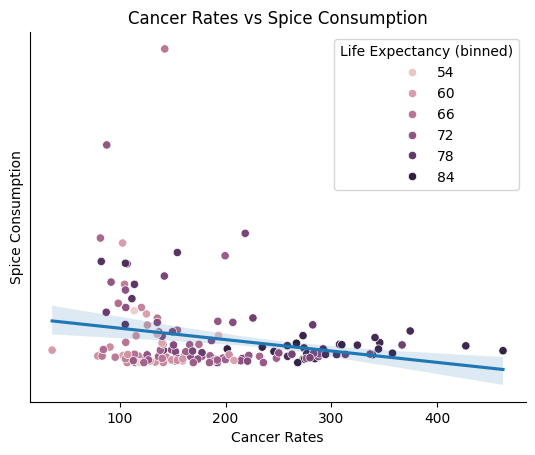

In [98]:
# Cancer rates vs Spice consumption, color by life expectancy
plot = sns.scatterplot(data=df, x="ASR", y="2019", hue="life_expectancy")
# Plot a trendline
sns.regplot(data=df, x="ASR", y="2019", scatter=False)

sns.despine()
# Legend titled Life Expectancy
plot.legend(title="Life Expectancy (binned)")
plot.set_title("Cancer Rates vs Spice Consumption")
plot.set_xlabel("Cancer Rates")
plot.set_ylabel("Spice Consumption")
# No y-axis labels
plot.set_yticklabels([])
# No y ticks
plot.set_yticks([])

## Cancer rates vs Life expectancy

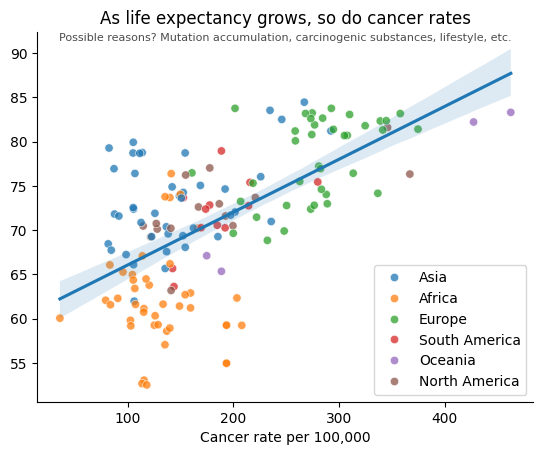

In [99]:
# Scatter plot of cancer rates sorted by life expectancy, with country on x-axis and ASR on y-axis, color by continent
plot = sns.scatterplot(data=df, x="ASR", y="life_expectancy", hue="continent", alpha=0.75)
# Trendline
plot = sns.regplot(data=df, x="ASR", y="life_expectancy", scatter=False)
sns.despine()
plot.text(
    x=0.5,
    y=0.97,
    s="Possible reasons? Mutation accumulation, carcinogenic substances, lifestyle, etc.",
    fontsize=8,
    alpha=0.7,
    ha="center",
    va="bottom",
    transform=plot.transAxes,
)

# Title, legend etc
plot.set_title("As life expectancy grows, so do cancer rates")
plot.set_xlabel("Cancer rate per 100,000")
plot.set_ylabel("")
plot.legend(title="")
# ax.set_xticklabels("")
# No x ticks
# ax.set_xticks([])


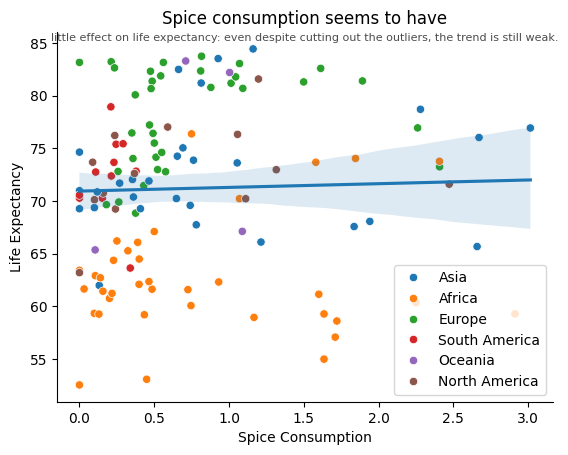

In [100]:
data = df[df["2019"] < df["2019"].nlargest(20).min()]

# Life expectancy vs spice consumption (without top 20 countries by spice consumption)
plot = sns.scatterplot(
    data=data,
    x="2019",
    y="life_expectancy",
    hue="continent",
)

# No axes on plot
sns.despine()

# plot = sns.scatterplot(data=df, x="2019", y="life_expectancy", hue="continent")
# Trendline
sns.regplot(data=data, x="2019", y="life_expectancy", scatter=False)

# Y-axis label is life expectancy
plot.set_ylabel("Life Expectancy")

# X-axis label is spice consumption
plot.set_xlabel("Spice Consumption")

# Title
plot.set_title("Spice consumption seems to have")

# Subtitle
plot.text(
    x=0.5,
    y=0.97,
    s="little effect on life expectancy: even despite cutting out the outliers, the trend is still weak.",
    fontsize=8,
    alpha=0.7,
    ha="center",
    va="bottom",
    transform=plot.transAxes,
)

# No legend
plot.legend(title="")

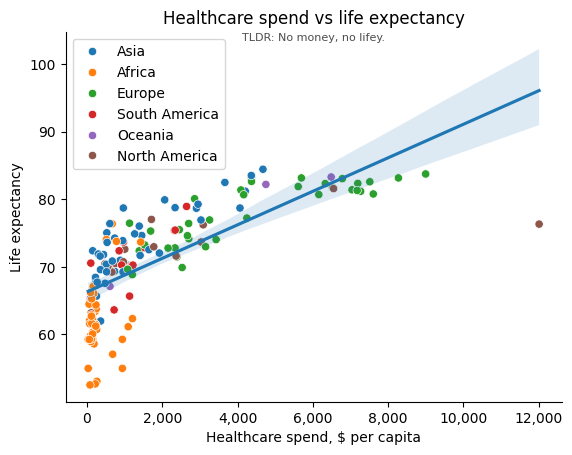

In [106]:
# Healthcare spend vs life expectancy
plot = sns.scatterplot(data=df, x="healthcare_spend", y="life_expectancy", hue="continent")
# Trendline
sns.regplot(data=df, x="healthcare_spend", y="life_expectancy", scatter=False)

# Axes
sns.despine()
plot.set_title("Healthcare spend vs life expectancy")
plot.set_xlabel("Healthcare spend, $ per capita")
plot.set_ylabel("Life expectancy")
plot.text(
    x=0.5,
    y=0.97,
    s="TLDR: No money, no lifey.",
    fontsize=8,
    alpha=0.7,
    ha="center",
    va="bottom",
    transform=plot.transAxes,
)

# No legend title
plot.legend(title="")

# Format x-axis as currency
plot.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

<Axes: xlabel='2019', ylabel='healthcare_spend'>

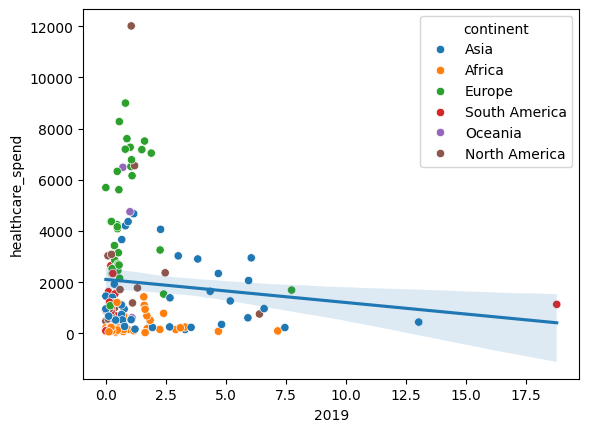

In [102]:
# Spice consumption vs healthcare spend
plot = sns.scatterplot(data=df, x="2019", y="healthcare_spend", hue="continent")
# Trendline
sns.regplot(data=df, x="2019", y="healthcare_spend", scatter=False)

<Axes: xlabel='healthcare_spend', ylabel='cancer_cases'>

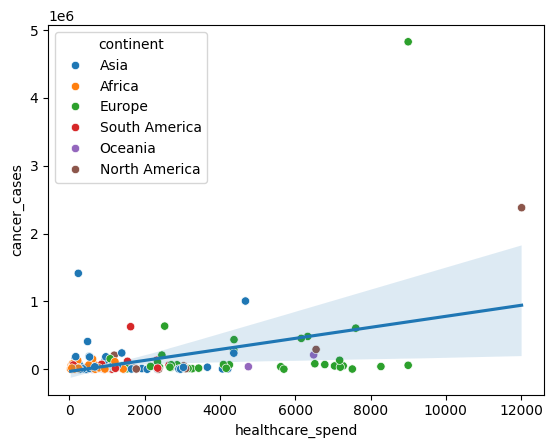

In [107]:
# Healthcare spend vs cancer cases
plot = sns.scatterplot(data=df, x="healthcare_spend", y="cancer_cases", hue="continent")
# Trendline
sns.regplot(data=df, x="healthcare_spend", y="cancer_cases", scatter=False)

## Do higher-income countries have better cancer survival rates?

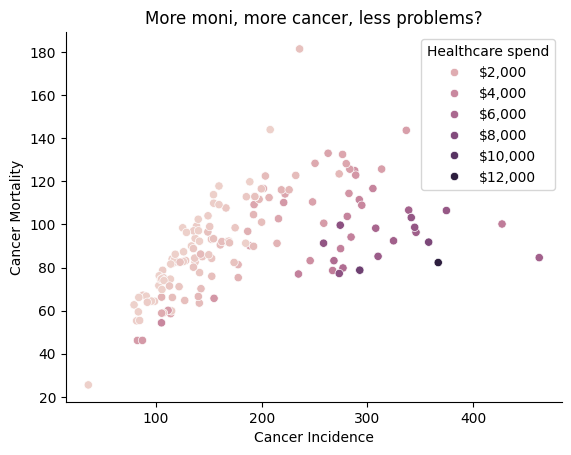

In [144]:
# Scatter plot: cancer incidence vs mortality, color by continent, size by healthcare spend
plot = sns.scatterplot(data=df, x="incidence_2022", y="mortality_2022", hue="healthcare_spend")


# Axis labels, legend, title, subtitle
plot.set_xlabel("Cancer Incidence")
plot.set_ylabel("Cancer Mortality")
plot.set_title("More moni, more cancer, less problems?")
plot.legend(title="Healthcare spend")

# Format legend as currency
plot.get_legend().set_title("Healthcare spend")

legend_texts = plot.get_legend().get_texts()
for i, text in enumerate(legend_texts):
    text.set_text(f"${int(legend_texts[i].get_text()):,}")


# Despine
sns.despine()

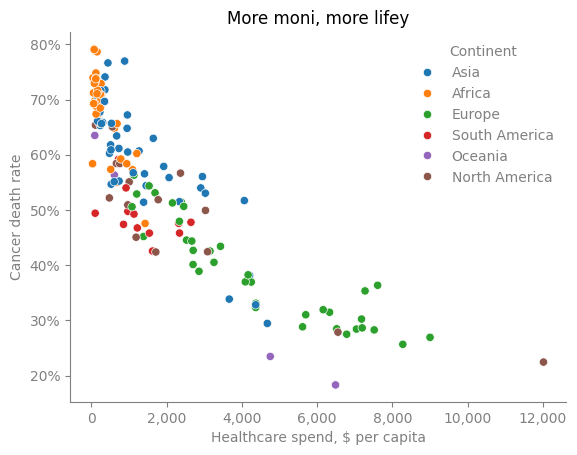

In [166]:
# Cancer death rate vs healthcare spend
df["death_rate"] = df["mortality_2022"] / df["incidence_2022"]

plot = sns.scatterplot(data=df, x="healthcare_spend", y="death_rate", hue="continent")

# Style the plot
plot = style_plot(
    plot,
    "Healthcare spend, $ per capita",
    "Cancer death rate",
    "More moni, more lifey",
    "Continent",
)

# Format x-axis as currency
plot.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

# Format y-axis as percentage
plot.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:.0%}")
)